<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_6_Point_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2021 Sudeep Sarkar, University of South Florida, Tampa 



# Point Features

Figure 4.2 and 4.3 in the textbook

Point features are stable with respect to viewpoint and lighting.


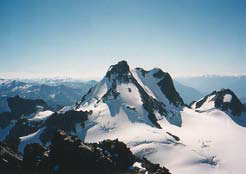
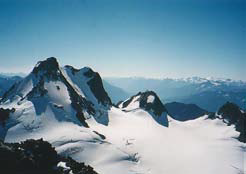


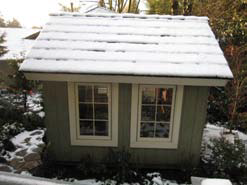
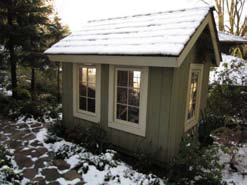


To track points across video frames or to match points across images one possible matching criterion is the **weighted sum of squared differences**.

\begin{equation}
    E_{WSSD}(\mathbf{u}) = \sum_i w(\mathbf{x}_i) \left (
        I_{1} (\mathbf{x}_i + \mathbf{u}) - I_0(\mathbf{x}_i) 
        \right )^2
\end{equation}

The value of this would be low when regions match, but could be low for other reason too, such as uniform colored patches.

Computationally, we will have to try to match every pixel to all other pixels in the other image to find matches. This is computationally expensive and also not unique for many points, such as along an edge or uniform colored surface.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/data/mountain_peak_1.png


Mounted at /content/drive
'/content/drive/MyDrive/Colab Notebooks/data/mountain_peak_1.png'


Input image size: (174, 246)
(25, 25)
(43, 23)


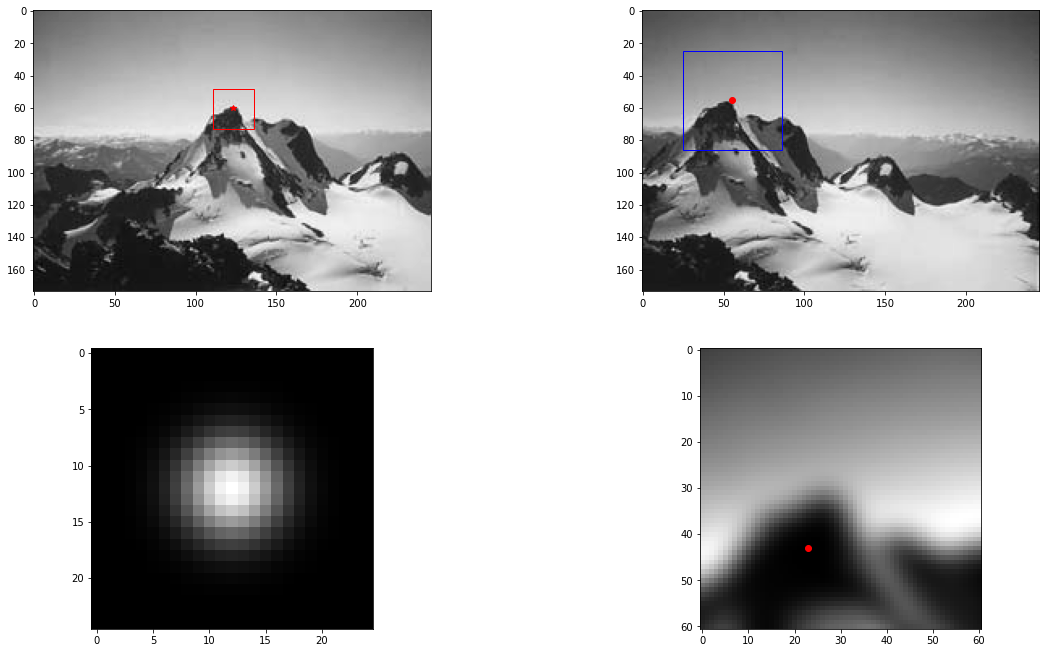

In [ ]:
#------------------------------------------------------------------
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage as scimage

np.set_printoptions(precision=2)
                     
def gaussian_weights (sigma) :
    N = np.round(3*(sigma+1))
    t = np.arange(-N, N)  # Note the width of the kernel, need to be this large to capture most of the shape
    g_2D = np.zeros ([2*N+1, 2*N+1])
    for i in range (-N, N):
        for j in range (-N, N):
            g_2D [i+N, j+N] = np.exp(-((i**2 + j**2)/(2*sigma*sigma)))*(1/(2*np.pi*sigma*sigma))
    return (g_2D/g_2D.sum())


# Load an color image in grayscale
img1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/mountain_peak_1.png')

img2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/mountain_peak_2.png')

# Change color spaces. Can experiment with other spaces.
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img1 = img1.astype(np.float)  # need to change type from uint8 to float
img2 = img2.astype(np.float)  # need to change type from uint8 to float
print("Input image size:", img1.shape)

# Compute E_WSSD over a (2Nw+1) by (2Nw+1) region for a point p in img1 computed 
# across a region (2Ns + 1) by (2Ns + 1) region in the img2 centered at point q
# in reality you will have to over all possible choices of p and q
px, py = (123, 60) # point in image 1
qx, qy = (55, 55) # point in image 2
sigma = 3
Nw = np.round(3*(sigma+1)) # averaging window
Ns = 30 # matching search region is (2Ns + 1) by (2Ns + 1)

weights = gaussian_weights (sigma)
print(weights.shape)

out = np.zeros([2*Ns+1, 2*Ns+1])
for i in range (-Ns, Ns+1) :
    for j in range (-Ns, Ns+1) :
        patch1 = img1[px-Nw : px+Nw+1, py-Nw : py+Nw+1]
        patch2 = img2[qx+i-Nw : qx+i+Nw+1 , qy+j-Nw : qy+j+Nw+1]
        out[i+Ns, j+Ns]  =  (weights*(patch1 - patch2)**2).sum()

#-----------------------------------------------------------------------------
# Plot the results
plt.figure(figsize=(20,30))
plt.subplot(5,2,1)
plt.imshow(img1, 'gray')
plt.plot (123, 60, 'r*')
rect = patches.Rectangle((px-Nw,py-Nw),weights.shape[0], weights.shape[1],linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
ax.add_patch(rect)

plt.subplot(5,2,2)
plt.imshow(img2, 'gray')
plt.plot (55, 55, 'ro')
rect = patches.Rectangle((qx-Ns,qy-Ns),out.shape[0], out.shape[1],linewidth=1,edgecolor='b',facecolor='none')
ax = plt.gca()
ax.add_patch(rect)

plt.subplot(5,2,3)
plt.imshow(weights, 'gray')
plt.subplot(5,2,4)
plt.imshow(out, 'gray')
print(np.unravel_index(np.argmin(out, axis=None), out.shape))

i_min, j_min = (np.unravel_index(np.argmin(out, axis=None), out.shape)) 
plt.plot (j_min, i_min, 'ro')


#plt.imshow(gaussian_weights (3), 'gray')

How can one **pre-select** a limited number of points to match? Find points in image such as the error criterion is stable with respect to small variations, on the same image. (see Fig 4.5)

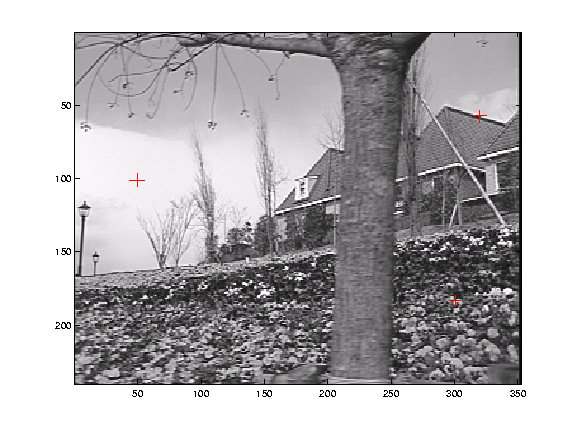


# Auto-correlation

Points in an image that are good to match will most likely have unique matches in the other image. One way is to select pixels that are **locally** stable matches in the **same** image. We consider the **auto-correlation** function defined as:

\begin{eqnarray}
        E_{AC}(\Delta \mathbf{u}) =  \sum_i w(\mathbf{x}_i) \left (
        I_0 (\mathbf{x}_i + \Delta \mathbf{u}) - I_0(\mathbf{x}_i) 
        \right )^2
\end{eqnarray}

(30, 30)


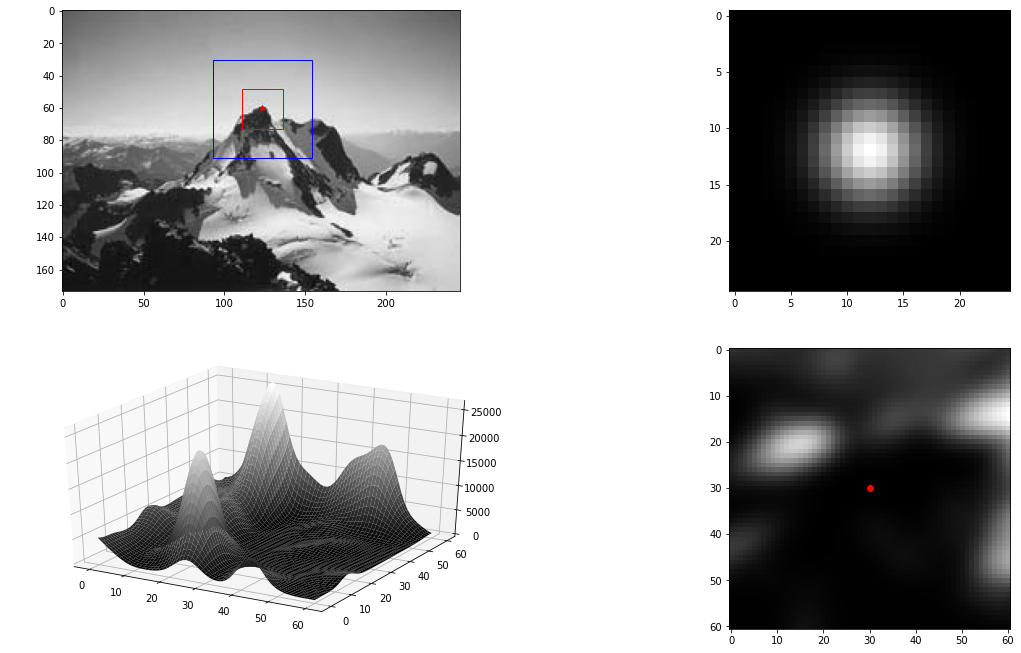

In [ ]:
#------------------------------------------------------------------
# Compute E_AC over a (2Nw+1) by (2Nw+1) region for a point p in img1 computed 
# across a region (2Ns + 1) by (2Ns + 1) region 

px, py = (100, 80)
px, py = (60, 60)
px, py = (123, 60) # point in image 1


sigma = 3
Nw = np.round(3*(sigma+1)) # averaging window
Ns = 30 # matching search region is (2Ns + 1) by (2Ns + 1)

weights = gaussian_weights (sigma)

out = np.zeros([2*Ns+1, 2*Ns+1])
for i in range (-Ns, Ns+1) :
    for j in range (-Ns, Ns+1) :
        patch1 = img1[px-Nw : px+Nw+1, py-Nw : py+Nw+1]
        patch2 = img1[px+i-Nw : px+i+Nw+1 , py+j-Nw : py+j+Nw+1]
        out[i+Ns, j+Ns]  =  (weights*(patch1 - patch2)**2).sum()

#-----------------------------------------------------------------------------
# Plot the results
plt.figure(figsize=(20,30))
plt.subplot(5,2,1)
plt.imshow(img1, 'gray')
plt.plot (px, py, 'r*')
rect = patches.Rectangle((px-Nw,py-Nw),weights.shape[0], weights.shape[1],linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
rect = patches.Rectangle((px-Ns,py-Ns),out.shape[0], out.shape[1],linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(rect)

plt.subplot(5,2,2)
plt.imshow(weights, 'gray')
plt.subplot(5,2,4)
plt.imshow(out, 'gray')
print(np.unravel_index(np.argmin(out, axis=None), out.shape))

i_min, j_min = (np.unravel_index(np.argmin(out, axis=None), out.shape)) 
plt.plot (j_min, i_min, 'ro')

# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:out.shape[0], 0:out.shape[1]]
# create the figure
plt.subplot(5,2,3,projection='3d')
ax = plt.gca ()
ax.plot_surface(xx, yy, out ,rstride=1, cstride=1, cmap=plt.cm.gray,
        linewidth=0)

#plt.imshow(gaussian_weights (3), 'gray')



This function is defined over a window of possible displacments $\Delta \mathbf{u} = \left [ \begin{array}{c} \Delta x \\ \Delta y \end{array} \right ]$. The sum on the R.H.S is also over a window but defined over the image grid. A good point will have an $E_{AC}$ that is peaked in the window over *local displacements*. 

(see Fig 4.5 in the textbook for examples of good and bad $E_{AC}$.)

To find these points with good $E_{AC}$, we still have to search through all pixels in the image, performing multiply-add in four for-loops! This is still computationally expensive.

We observe that this error criterion is on the *same* image and needed for *small* displacements. So, we can approximate it using the Taylor expansion to arrive a computationally simpler expression.

Using Taylor series expansion

\begin{eqnarray}
        I_0 (\mathbf{x}_i + \Delta\mathbf{u}) & \approx & 
        I_0 (\mathbf{x}_i) + \nabla I_0 (\mathbf{x}_i)^T \Delta   
        \mathbf{u} \\
        & = & I_0 (\mathbf{x}_i) + 
        \begin{bmatrix} I_x (\mathbf{x}_i) & I_y (\mathbf{x}_i) \end{bmatrix} \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}
\end{eqnarray}



Using the above approximation of the image function value in a local neighborhood using derivatives, we can approximate the $E_{AC}$ as below.

\begin{eqnarray}
        E_{AC}(\Delta \mathbf{u}) & = &   \sum_i w(\mathbf{x}_i) \left (
        I_0 (\mathbf{x}_i + \Delta \mathbf{u}) - I_0(\mathbf{x}_i) 
        \right )^2 \\
        & \approx & \sum_i w(\mathbf{x}_i) \left (
        \nabla I_0 (\mathbf{x}_i)^T \Delta \mathbf{u} \right )^2 \\
        & = & \sum_i w(\mathbf{x}_i) \left (
        \nabla I_0 (\mathbf{x}_i)^T \Delta \mathbf{u} \right )^T 
        \left (
        \nabla I_0 (\mathbf{x}_i)^T \Delta \mathbf{u} \right ) \\
        & = & \sum_i w(\mathbf{x}_i) 
        \begin{bmatrix} \Delta x & \Delta y 
        \end{bmatrix}
        \begin{bmatrix} I_x (\mathbf{x}_i) \\ I_y (\mathbf{x}_i) \end{bmatrix} 
        \begin{bmatrix} I_x (\mathbf{x}_i) & I_y (\mathbf{x}_i) \end{bmatrix} \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix} \\
        & = & 
        \begin{bmatrix} \Delta x & \Delta y 
        \end{bmatrix} \left (
        \sum_i w(\mathbf{x}_i) \begin{bmatrix} I_x (\mathbf{x}_i) \\ I_y 
        (\mathbf{x}_i) \end{bmatrix} 
        \begin{bmatrix} I_x (\mathbf{x}_i) & I_y (\mathbf{x}_i) \end{bmatrix} 
        \right )
        \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}  \\
        & = & 
        \begin{bmatrix} \Delta x & \Delta y 
        \end{bmatrix} \mathbf{A} 
        \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}
    \end{eqnarray}
    
\begin{equation}
        \mathbf{A}  = \begin{bmatrix}
            \sum_i w(\mathbf{x}_i) I_x^2 (\mathbf{x}_i) & 
            \sum_i w(\mathbf{x}_i) I_x (\mathbf{x}_i) I_y (\mathbf{x}_i) \\
            \sum_i w(\mathbf{x}_i) I_y (\mathbf{x}_i) I_x (\mathbf{x}_i)  & 
            \sum_i w(\mathbf{x}_i) I_y^2 (\mathbf{x}_i)
        \end{bmatrix}
\end{equation}

\begin{equation}
        \mathbf{A}  = 
        \begin{bmatrix}
            \sum_i w(\mathbf{x}_i) I_x^2 & 
            \sum_i w(\mathbf{x}_i) I_x  I_y  \\
            \sum_i w(\mathbf{x}_i) I_y  I_x   & 
            \sum_i w(\mathbf{x}_i) I_y^2 
        \end{bmatrix}
\end{equation}
    
\begin{equation}
          \mathbf{A}  = \sum_i w(\mathbf{x}_i)   \begin{bmatrix}
           I_x^2 &  I_x  I_y  \\
            I_y  I_x   &  I_y^2 
        \end{bmatrix}
\end{equation}
    
The matrix $\mathbf{A}$ is an estimate of the local image tensor, defined using first derivatives at the pixel location underconsideration. Note that the form of the approximated $E_{AC}$ function is parabolic function over the displacements $\Delta x$ and $\Delta y$. The shape of the paraboloid is dependent on $\mathbf{A}$. 
    

Input image size: (174, 246)

 Image tensor (A) at pixel 123 60 is
 [[0.33 0.36]
 [0.36 2.28]]
(30, 30)


<Figure size 1440x2160 with 0 Axes>

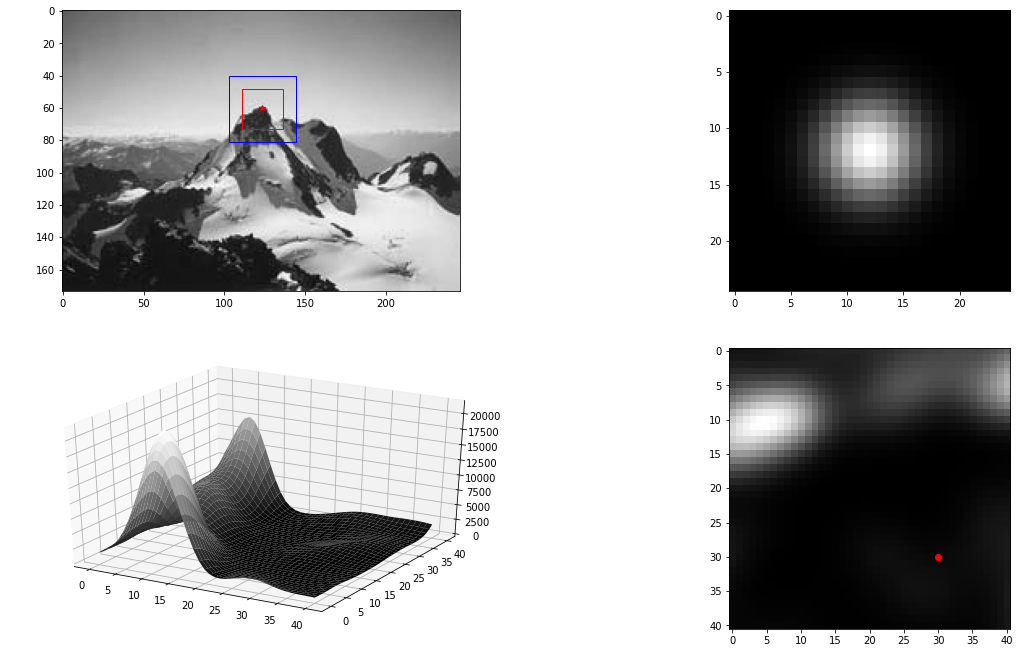

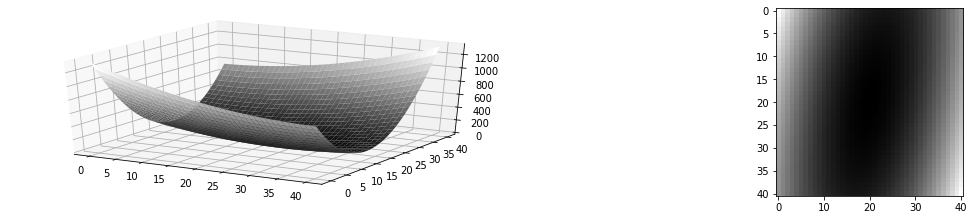

In [ ]:
def gaussian (x, sigma):
    g = np.exp(-(x**2/(2*sigma*sigma)))*(1/(np.sqrt(2*np.pi)*sigma))
    return (g/g.sum())
#------------------------------------------------------------------
def first_derivative_of_gaussian (x, sigma):
    dg = np.exp(-(x**2/(2*sigma*sigma)))*(-x/(np.sqrt(2*np.pi)*sigma**3))
    return (dg)

#------------------------------------------------------------------
def image_convolve_gradient_gaussian (image, sigma) :
    N = np.round(3*(sigma+1))
    t = np.arange(-N, N)  # Note the width of the kernel, need to be this large to capture most of the shape
    g = gaussian(t, sigma) # 1D gaussian kernel
    dg = first_derivative_of_gaussian(t, sigma) # 1D first derivative gaussian kernel
    #print("Size of 1D kernel:", g.shape, dg.shape)
    #plt.subplot(5,2,1)
    #plt.plot(t, g, 'o-')
    #plt.title('Gaussian kernel')
    #plt.subplot(5,2,2)
    #plt.plot(t, dg, 'x-')
    #plt.title('first derivative of Gaussian kernel')

    # Process rows
    gradX = image.copy()
    for i in range (image.shape[0]):
        gradX[i,:] = scimage.convolve(gradX[i, :], dg)
    # Process columns
    for j in range (image.shape[1]):
        gradX[:, j] = scimage.convolve(gradX[:, j], g)

    gradY = image.copy()
    for i in range (image.shape[0]):
        gradY[i,:] = scimage.convolve(gradY[i, :], g)
    # Process columns
    for j in range (image.shape[1]):
        gradY[:, j] = scimage.convolve(gradY[:, j], dg)

    return (gradX, gradY)

#------------------------------------------------------------------
# Load an color image in grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/mountain_peak_1.png')

# Change color spaces. Can experiment with other spaces.
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("Input image size:", img.shape)
plt.figure(figsize=(20,30))
img = img.astype(np.float)  # need to change type from uint8 to float
sigma = 3
Nw = np.round(3*(sigma+1)) # averaging window
Ns = 20 # matching search region is (2Ns + 1) by (2Ns + 1)
weights = gaussian_weights (sigma)
#-----------------------select point on the image to explore------------
px, py = (100, 80)
px, py = (60, 60)
px, py = (123, 60) # point in image 1

#-----------------------Raw Autocorrelation E_WSSD--------------------------------
E_WSSD = np.zeros([2*Ns+1, 2*Ns+1])
for i in range (-Ns, Ns+1) :
    for j in range (-Ns, Ns+1) :
        patch1 = img1[px-Nw : px+Nw+1, py-Nw : py+Nw+1]
        patch2 = img1[px+i-Nw : px+i+Nw+1 , py+j-Nw : py+j+Nw+1]
        E_WSSD[i+Ns, j+Ns]  =  (weights*(patch1 - patch2)**2).sum()

#-----------------------Approximate Autocorrelation--------------------------------

image_dx, image_dy = image_convolve_gradient_gaussian(img, 3)

Ix_Ix = image_dx*image_dx
Ix_Iy = image_dx*image_dy
#A_10 = image_dy*image_dx # do not need it
Iy_Iy = image_dy*image_dy

A = np.zeros((2,2,img.shape[0], img1.shape[1]))
A[0, 0,:,:] = scimage.convolve(Ix_Ix, weights)
A[0, 1,:,:] = scimage.convolve(Ix_Iy, weights)
A[1, 0,:,:] = A[0, 1,:,:]
#scimage.convolve(A_10, g)
A[1, 1,:,:] = scimage.convolve(Iy_Iy, weights)

print('\n Image tensor (A) at pixel', px, py, 'is\n', A[:,:,px,py])
#-----------------------E_AC--------------------------------
E_AC = np.zeros((2*Ns+1, 2*Ns+1))
for i in range(-Ns, Ns+1) :
    for j in range (-Ns, Ns+1) :
        E_AC [i+Ns, j+Ns] = np.array([[i, j]]) @ A[:,:,px,py] @ np.array([[i], [j]])

#-----------------------------------------------------------------------------
# Plot the results
plt.figure(figsize=(20,30))
plt.subplot(5,2,1)
plt.imshow(img1, 'gray')
plt.plot (px, py, 'r*')
rect = patches.Rectangle((px-Nw,py-Nw),weights.shape[0], weights.shape[1],linewidth=1,edgecolor='r',facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
rect = patches.Rectangle((px-Ns,py-Ns),E_WSSD.shape[0], E_WSSD.shape[1],linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(rect)

plt.subplot(5,2,2)
plt.imshow(weights, 'gray')
plt.subplot(5,2,4)
plt.imshow(E_WSSD, 'gray')
print(np.unravel_index(np.argmin(E_WSSD, axis=None), out.shape))

i_min, j_min = (np.unravel_index(np.argmin(E_WSSD, axis=None), E_WSSD.shape)) 
plt.plot (j_min, i_min, 'ro')

# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:E_WSSD.shape[0], 0:E_WSSD.shape[1]]
# create the figure
plt.subplot(5,2,3,projection='3d')
ax = plt.gca ()
ax.plot_surface(xx, yy, E_WSSD ,rstride=1, cstride=1, cmap=plt.cm.gray,
        linewidth=0)
# create the x and y coordinate arrays (here we just use pixel indices)

# create the figure
plt.figure(figsize=(20,20))
plt.subplot(5,2,5, projection='3d')
ax = plt.gca ()
ax.plot_surface(xx, yy, E_AC, rstride=1, cstride=1, cmap=plt.cm.gray, linewidth=0)
plt.subplot(5,2,6)
plt.imshow(E_AC, 'gray');

# Harris Points

$\mathbf{A}^{-1}$ is a measure of the uncertainty of the location, i.e. how sharp the valley is?

If $\lambda_0$ and $\lambda_1$ are eigenvalues of A, where $\lambda_0 < \lambda_1$, then $\lambda_0^{-1}$ and $\lambda_1^{-1}$ are the eigenvalues of $\mathbf{A}^{-1}$. The largest eigenvalue of $\mathbf{A}^{-1}$ should be small, i.e. $\lambda_0^{-1}$ should be small, or in other words $\lambda_0$ should be high (Shi and Tomasi).
    
$\lambda_0 \lambda_1 = \det(\mathbf{A}) = A_{00} A_{11} - A_{01}A_{10}$ and $\lambda_0 + \lambda_1 = Trace(\mathbf{A}) = A_{00} + A_{11}$
    
For **Harris points:** $\lambda_0 \lambda_1 - \alpha (\lambda_0 + \lambda_1)^2$ should be high, typically $\alpha = 0.06$
    
Others suggest the harmonic mean, $\frac{\lambda_0 \lambda_1} {\lambda_0 + \lambda_1}$
    



 Eigenvalues: 48.0 16.0

 Harris Measure: 522.24 522.24


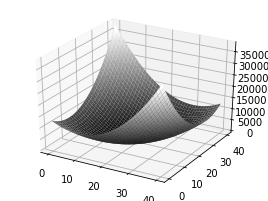

In [ ]:
# Playing around with different values of the A matrix

A = np.array([[1, 0],[0, 1]])
A = np.array([[1, 0.2],[0.2, 5]])
A = np.array([[32, -16],[-16, 32]])

eig,_ = np.linalg.eig(A)
print('\n Eigenvalues:', eig[0], eig[1])

harris_measure = eig[0]*eig[1] - 0.06*(eig[0]+eig[1])**2
print('\n Harris Measure:', harris_measure, A[0,0]*A[1,1] - A[0,1]*A[1,0] - 0.06*(A[0,0]+A[1,1])**2)

E_AC = np.zeros((2*Ns+1, 2*Ns+1))
for i in range(-Ns, Ns+1) :
    for j in range (-Ns, Ns+1) :
        E_AC [i+Ns, j+Ns] = np.array([[i, j]]) @ A @ np.array([[i], [j]])
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:E_AC.shape[0], 0:E_AC.shape[1]]
# create the figure

plt.figure(figsize=(10,20))
plt.subplot(5,2,1,projection='3d')
ax = plt.gca ()
ax.plot_surface(xx, yy, E_AC ,rstride=1, cstride=1, cmap=plt.cm.gray,
        linewidth=0)

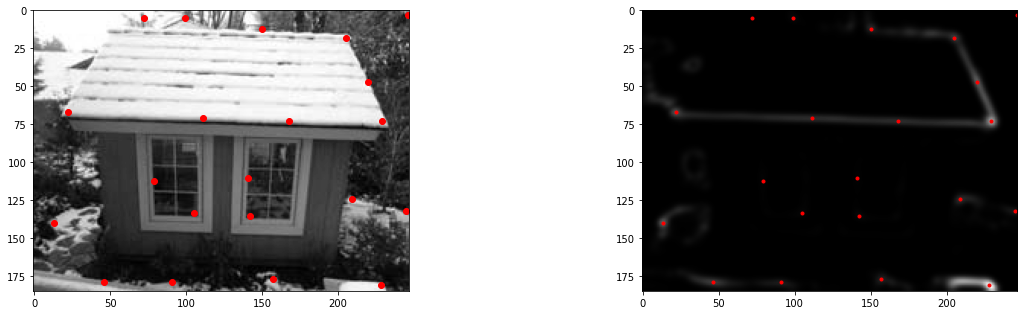

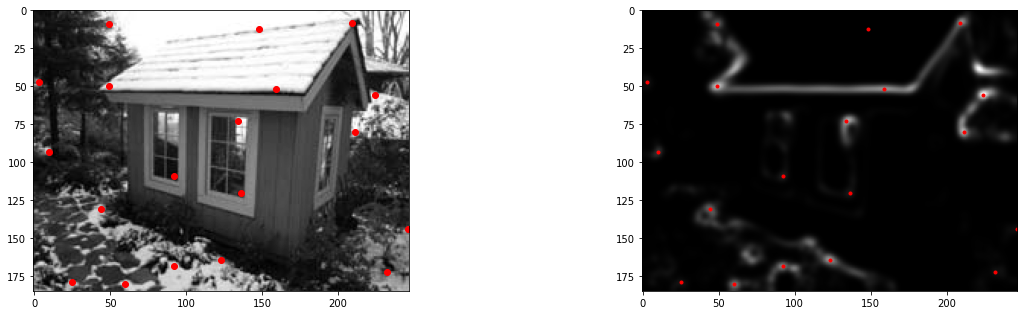

In [ ]:
from skimage.feature import peak_local_max
import numpy as np
import cv2
import matplotlib.pyplot as plt

#------------------------------------------------------------------

def detect_harris_points (image, sigma=3,min_distance=20) :

    weights = gaussian_weights (sigma)
    image_dx, image_dy = image_convolve_gradient_gaussian(image, 3)

    Ix_Ix = image_dx*image_dx
    Ix_Iy = image_dx*image_dy
    Iy_Iy = image_dy*image_dy

    A = np.zeros((2,2,image.shape[0], image.shape[1]))
    A[0, 0,:,:] = scimage.convolve(Ix_Ix, weights)
    A[0, 1,:,:] = scimage.convolve(Ix_Iy, weights)
    A[1, 0,:,:] = A[0, 1,:,:]
    A[1, 1,:,:] = scimage.convolve(Iy_Iy, weights)

    det_A = A[0, 0,:,:]*A[1, 1,:,:] - A[0, 1,:,:]*A[1, 0,:,:] 
    trace_A = A[0, 0,:,:] + A[1, 1,:,:]
    harris_measure = det_A + 0.06 * trace_A**2

    coordinates = peak_local_max(harris_measure, min_distance=20, exclude_border=False)
    return(coordinates, harris_measure)

#----------------------------------------------------------------------------
# Load an color image in grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/house_1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
img = img.astype(np.float)  # need to change type from uint8 to float
coordinates, harris_measure = detect_harris_points (img, sigma=2, min_distance=20)

# Plot the results
plt.figure(figsize=(20,30))
plt.subplot(5,2,1)
plt.imshow(img, 'gray')
plt.plot(coordinates[:, 1], coordinates[:, 0], 'ro')

plt.subplot(5,2,2)
plt.imshow(harris_measure, 'gray')
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

#-----------------------------------------------------------------------------
# Load an color image in grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/house_2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
img = img.astype(np.float)  # need to change type from uint8 to float
coordinates, harris_measure = detect_harris_points (img, sigma=2, min_distance=20)

# Plot the results
plt.figure(figsize=(20,30))
plt.subplot(5,2,3)
plt.imshow(img, 'gray')
plt.plot(coordinates[:, 1], coordinates[:, 0], 'ro')

plt.subplot(5,2,4)
plt.imshow(harris_measure, 'gray')
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')





# Feature tracking 

Section 4.1.4. We expect motion from frame to frame is small.

1. Detect stable features in one frame.

2. Correlate patches over small neighborhoods and pick point of smallest squared difference.
    
3. If features are tracked over long sequences, appearance can change, so need to update template, but not too often.

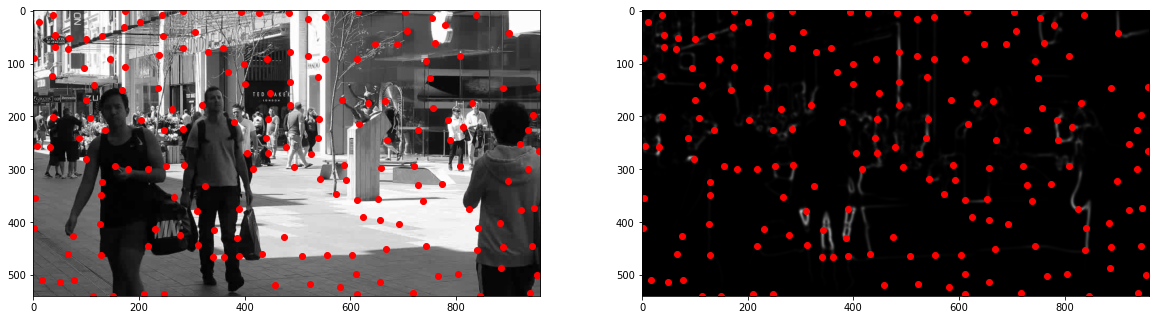

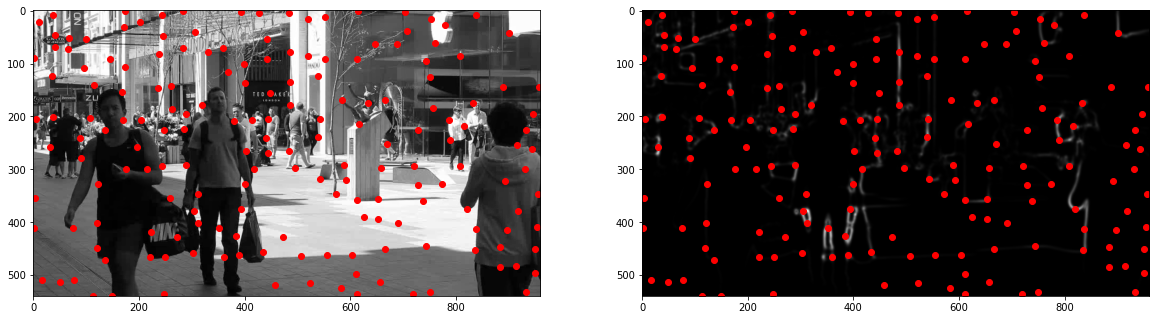

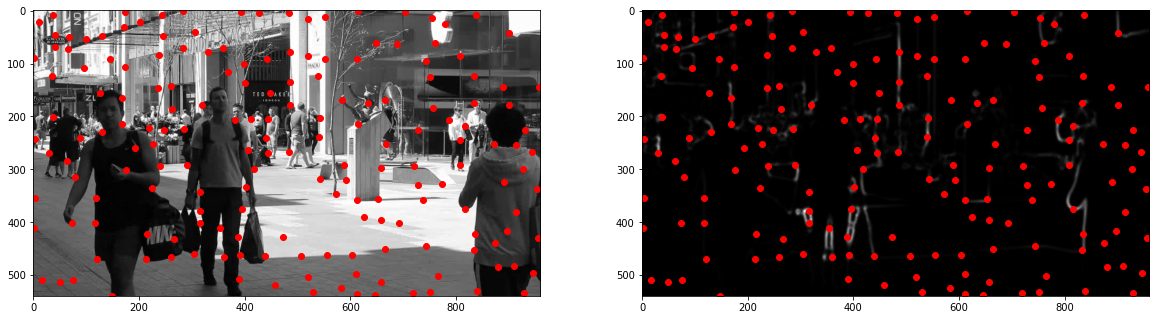

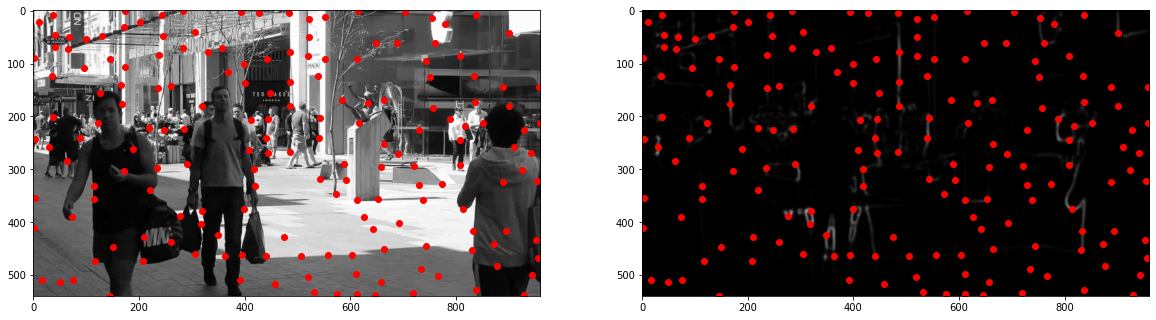

KeyboardInterrupt: ignored

In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/data/MOT16-08-raw.webm')

if (cap.isOpened()== False): 
    print("Error opening video stream or file")

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype(np.float)  # need to change type from uint8 to float
        coordinates, harris_measure = detect_harris_points (frame, sigma=2, min_distance=20)
        # Plot the results
        plt.figure(figsize=(20,30))
        plt.subplot(1,2,1)
        plt.imshow(frame, 'gray')
        plt.plot(coordinates[:, 1], coordinates[:, 0], 'ro')
        plt.subplot(1,2,2)
        plt.imshow(harris_measure, 'gray')
        plt.plot(coordinates[:, 1], coordinates[:, 0], 'ro')
        
        plt.pause(10)

    else: 
	    break

cap.release()
 
cv2.destroyAllWindows()